In [2]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
%matplotlib inline 
%precision 5

u'%.5f'

In [36]:
def A(x):
    A0 = 0.1
    return -2*A0/(x-2)

def u_exact(x):
    u0 = 1e-3
    return (1./3)*u0*((x-2)**2-1)


In [37]:
# Some of the parameters (defined in the class notes)

u0 = 1e-3
A0 = 0.1
E = 30e6
P = (4./3)*u0*A0*E
print(P)

4000.0


In [38]:
## Quadratic shape functions 
def N1(x,x1e,x2e,x3e):
    return (x-x2e)*(x-x3e)/((x1e-x2e)*(x1e-x3e))

def N2(x,x1e,x2e,x3e):
    return (x-x1e)*(x-x3e)/((x2e-x1e)*(x2e-x3e))

def N3(x,x1e,x2e,x3e):
    return (x-x1e)*(x-x2e)/((x3e-x1e)*(x3e-x2e))

def dN1dx(x,x1e,x2e,x3e):
    return (x-x3e)/((x1e-x2e)*(x1e-x3e))+(x-x2e)/((x1e-x2e)*(x1e-x3e))

def dN2dx(x,x1e,x2e,x3e):
    return (x-x3e)/((x2e-x1e)*(x2e-x3e))+(x-x1e)/((x2e-x1e)*(x2e-x3e))

def dN3dx(x,x1e,x2e,x3e):
    return (x-x2e)/((x3e-x1e)*(x3e-x2e))+(x-x1e)/((x3e-x1e)*(x3e-x2e))

In [54]:
## Finite element solution

# pre processing 
n_ele = 1
n_node = 3
node_X = np.array([1.,0.5,0.0])
elements = np.array([[3,2,1]])

# assemble global stiffness 
K = np.zeros((n_node,n_node))

# integration scheme
gauss_2 = np.array([[-1./np.sqrt(3.),1.],[1./np.sqrt(3.),1]])
gauss_3 = np.array([[-np.sqrt(3./5.),5./9.],[0,8./9.],[np.sqrt(3./5.),5./9.]])
gauss_4 = np.array([[-0.861136,0.347855],[-0.339981,0.652145],[0.339981,0.652145],[0.861136,0.347855]])
gauss_5 = np.array([[-0.90618,0.236927],[-0.538469,0.478629],[0,0.568889],[0.538469,0.478629],[0.90618,0.236927]])

# Loop over elements 
for i in range(n_ele):
    
    # 'x' coordinates of this element 
    x1e = node_X[elements[i,0]-1]
    x2e = node_X[elements[i,1]-1]
    x3e = node_X[elements[i,2]-1]
    le = x3e-x1e 
    J = le/2.
    
    # stiffness matrix for this element, gauss quadrature with 3 points 
    Ke = np.zeros((3,3))
    for ip in range(len(gauss_2)):
        x_i = 0.5*(x1e+x3e) + 0.5*gauss_2[ip,0]*le
        dNdx = np.array([dN1dx(x_i,x1e,x2e,x3e),dN2dx(x_i,x1e,x2e,x3e),dN3dx(x_i,x1e,x2e,x3e)])
        Ke += J*gauss_2[ip,1]*A(x_i)*E*np.outer(dNdx,dNdx)
    
    # Assemble into global stiffness 
    K[elements[i,0]-1,elements[i,0]-1] += Ke[0,0]
    K[elements[i,0]-1,elements[i,1]-1] += Ke[0,1]
    K[elements[i,0]-1,elements[i,2]-1] += Ke[0,2]
    K[elements[i,1]-1,elements[i,0]-1] += Ke[1,0]
    K[elements[i,1]-1,elements[i,1]-1] += Ke[1,1]
    K[elements[i,1]-1,elements[i,2]-1] += Ke[1,2]
    K[elements[i,2]-1,elements[i,0]-1] += Ke[2,0]
    K[elements[i,2]-1,elements[i,1]-1] += Ke[2,1]
    K[elements[i,2]-1,elements[i,2]-1] += Ke[2,2]

print(K)

[[ 11538461.53846 -12923076.92308   1384615.38462]
 [-12923076.92308  22153846.15385  -9230769.23077]
 [  1384615.38462  -9230769.23077   7846153.84615]]


In [55]:
# solve

# solving the system with matrix partitioning 
n_E = 1 # the first node has an essential boundary condition
n_F = 2 # the other 5 nodes are free
K_E = K[0:n_E,0:n_E]
K_F = K[n_E:,n_E:]
K_EF = K[0:n_E,n_E:]
# known displacement
u_E = np.array([0.])
# known external forces
F_F = np.array([0.,4000])
# solving A\b
u_F = np.linalg.solve(K_F,F_F- np.dot(K_EF.transpose(),u_E))
#print(u_F)
# Assemble the vector with all degrees of fredom [u_E,u_F]
u = np.zeros((n_node))
u[0:n_E] = u_E
u[n_E:] = u_F
print(u)

[0.      0.00042 0.001  ]


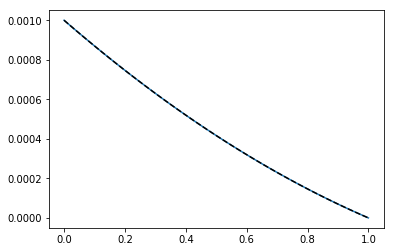

In [56]:
# Plot the calculated and exact solutions

# Loop over elements 
for i in range(n_ele):
    
    # 'x' coordinates of this element 
    x1e = node_X[elements[i,0]-1]
    x2e = node_X[elements[i,1]-1]
    x3e = node_X[elements[i,2]-1]
    
    # Nodal values of the function 'u'
    u1e = u[elements[i,0]-1]
    u2e = u[elements[i,1]-1]
    u3e = u[elements[i,2]-1]
    
    # Eval the shape function evaluation for multiple x
    x_vec = np.linspace(x1e,x3e,50)
    u_vec = N1(x_vec,x1e,x2e,x3e)*u1e + N2(x_vec,x1e,x2e,x3e)*u2e + N3(x_vec,x1e,x2e,x3e)*u3e
    
    # plot
    plt.plot(x_vec,u_vec,zorder=0)
x_ls = np.linspace(0,1,100)
plt.plot(x_ls,u_exact(x_ls),'--',zorder=1,color='black')